# Imports

In [1]:
# common / KNN imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import scipy.spatial.distance
from collections import Counter
import pandas as pd
import sklearn
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
plt.set_cmap('gray')

## Load Datasets / Subset functions

In [2]:
#-----------------------------------------------
# Load MNIST Data
#-----------------------------------------------
mnist_data = tf.keras.datasets.mnist.load_data()

# Get Training set
train = mnist_data[0]
x_mnist_train_full, y_mnist_train_full = train[0], train[1]

# Get Test set
test = mnist_data[1]
x_mnist_test_full, y_mnist_test_full = test[0], test[1]

n_mnist_train = x_mnist_train_full.shape[0]
n_mnist_test =x_mnist_test_full.shape[0]

m = x_mnist_train_full.shape[1]**2

x_mnist_train_full = x_mnist_train_full.reshape([n_mnist_train, m])
x_mnist_test_full = x_mnist_test_full.reshape([n_mnist_test, m])


In [3]:
#-----------------------------------------------
# Create MNIST Subset
#-----------------------------------------------

# Create train subset
#idx = np.random.randint(n_mnist_train, size= 1000)
#x_mnist_train = x_mnist_train_full[idx]
#y_mnist_train = y_mnist_train_full[idx]

# Create test subset
#idx = np.random.randint(n_mnist_test, size= 30)
#x_mnist_test = x_mnist_test_full[idx]
#y_mnist_test = y_mnist_test_full[idx]

def get_mnist_subsets(train_size, test_size):
    global n_mnist_train
    global n_mnist_test
    
    idx = np.random.randint(n_mnist_train, size= train_size)
    x_mnist_train = x_mnist_train_full[idx]
    y_mnist_train = y_mnist_train_full[idx]
    idx = np.random.randint(n_mnist_test, size= test_size)
    x_mnist_test = x_mnist_test_full[idx]
    y_mnist_test = y_mnist_test_full[idx]

    return {'x_train': x_mnist_train, 'y_train': y_mnist_train, 'x_test': x_mnist_test, 'y_test' : y_mnist_test}

In [4]:
#-----------------------------------------------
# Load CIFAR data
#-----------------------------------------------

cifar = tf.keras.datasets.cifar10.load_data()[0]
x_cifar, y_cifar = cifar[0], cifar[1]

# Convert to grayscale
x_cifar = np.dot(x_cifar[...,:3], [0.299, 0.587, 0.114])
print(x_cifar.shape)

n_x_cifar = x_cifar.shape[0]
m_x_cifar = x_cifar.shape[1]**2

x_cifar = x_cifar.reshape([n_x_cifar, m_x_cifar])


(50000, 32, 32)


In [5]:
#-----------------------------------------------
# Create Cifar Subset
#-----------------------------------------------
idx = np.random.randint(n_x_cifar, size=1030)
x_cifar_sample = x_cifar[idx]
y_cifar_sample = y_cifar[idx]

# Create test & train set
x_cifar_test = x_cifar_sample[:30]
y_cifar_test = y_cifar_sample[:30,0]

x_cifar_train = x_cifar_sample[30:]
y_cifar_train = y_cifar_sample[30:,0]

def get_cifar_subsets(train_size, test_size):
    global n_x_cifar
    global x_cifar_train
    global y_cifar_train
    global x_cifar_test
    global y_cifar_test
    
    idx = np.random.randint(n_x_cifar, size= train_size + test_size)
    x_cifar_sample = x_cifar[idx]
    y_cifar_sample = y_cifar[idx]

    # Create test & train set
    x_cifar_test = x_cifar_sample[:test_size]
    y_cifar_test = y_cifar_sample[:test_size,0]

    x_cifar_train = x_cifar_sample[test_size:]
    y_cifar_train = y_cifar_sample[test_size:,0]

    return {'x_train': x_cifar_train, 'y_train': y_cifar_train, 'x_test': x_cifar_test, 'y_test' : y_cifar_test}


## KNN Funktionen

In [6]:
def knn(k, x_train, y_train, x_test):
    dists = scipy.spatial.distance.cdist(x_train, x_test, metric='euclid')
    idx_nearest = np.argpartition(dists, k, axis=0)[:k]
    idx_nearest = np.swapaxes(idx_nearest, 0, 1)
    #print(idx_nearest)

    closest_points_labels = y_train[idx_nearest]
    y_test_predictions = []
    
    for index, predicted_labels in enumerate(closest_points_labels):
        y_test_predictions.append(np.bincount(predicted_labels).argmax())
    return y_test_predictions

In [7]:
def print_error_rate(y_test,  y_test_predictions):
    
    correct = 0
    
    correct_labels = (y_test)
    
    numbers_count = Counter(correct_labels)
    
    numbers_correct = dict.fromkeys(numbers_count.keys(), 0)
    
    wrongly_assigned = []
    
    #numbers_error_rate = dict.fromkeys(numbers_count.keys(), None)
    
    
    n = correct_labels.shape[0]
    
    for index, prediction in enumerate( y_test_predictions):
        if prediction == correct_labels[index]:
            correct += 1
            numbers_correct[prediction] += 1
        else:
            wrongly_assigned.append([index, prediction, correct_labels[index]])
            
    error_rate = 1- (correct / n)
        
            
    
    for key in sorted(numbers_count):
        count = numbers_count[key]
        correct = numbers_correct[key]
        error = 1 - numbers_correct[key] / numbers_count[key]
        print("Label:", key)
        print("  ", correct, "out of", count, "recognized correctly | Errorrate:", error*100, "%")
        
    print("\n"+"Resulting errorrate:", error_rate*100, "%")
    
    return np.array(wrongly_assigned)

## K-means Funktionen

In [8]:
def kmeans_start(x_train, k):

    global g_embedding
    global g_centroids
    global g_labels
    global g_k
    
    kmeans_number_of_classes = k
    
   
    _tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    embedding = _tsne.fit_transform(x_train)

    # init centroids
    idx_centroid = np.random.randint(x_train.shape[0], size=k)
    centroids = x_train[idx_centroid]
    
    # calc distances
    dists = scipy.spatial.distance.cdist(x_train, centroids, metric='euclid')
    
    # find nearest centroids
    labels = np.argmin(dists, axis=1)
    
    g_embedding = embedding
    g_centroids = centroids
    g_labels = labels
    g_k = k

In [9]:
def kmeans_train(it, x_train, y_train):
    
    global g_embedding
    global g_centroids
    global g_labels
    global g_k
    
    
    embedding = g_embedding
    centroids =  g_centroids
    labels = g_labels
    k =  g_k
    
    wrongly_assigned = []
        
    # train model for q iterations
    for j in range(it):
        
        if j == it-1: #Save centroids for visualization
            vis_cent_old = np.array([embedding[labels == i].mean(0) for i in range(k)])
        
        # calc distances
        dists = scipy.spatial.distance.cdist(x_train, centroids, metric='euclid')
        
        # label according to nearest centroids
        labels = np.argmin(dists, axis=1)
        
        # get new centroids
        centroid_list = [x_train[labels == i].mean(0) for i in range(k)]
        centroids = np.stack(centroid_list)
        
        
        # print results
        
    modes = []
    
    for i in range(k):
        size = y_train[labels == i].shape[0]
        
        bincount = np.bincount(y_train[labels == i])
        mode = bincount.argmax()
        
        modes.append(mode)
        
        
        correct = bincount[mode]
        percentage = correct / size
        print()
        print(i, "| Mayority:", mode)
        print("-------------------------------------")
        print("Size: mayority", correct, "| full:", size)
        print("Percentage of majority class:", percentage*100, "%", "\n")
        
        counter = 0
        for index, label in enumerate(labels):
            if label == i and y_train[index] != mode:
                
                wrongly_assigned.append([index, mode, y_train[index]])
                counter += 1
                if counter >= 4:
                    break;
                    
   
    not_represented = []
    modes = np.unique(modes)
    for i in range(9):
        if i not in modes:
            not_represented.append(i)
    print("Not represented:", not_represented)

    
    #visualization
    color_map = sns.color_palette("hls", k)
        
    colors_tmp = [color_map[l] for l in labels]
    
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors_tmp, alpha=0.5, marker ='x')
    
    
    vis_cent = np.array([embedding[labels == i].mean(0) for i in range(k)])
    color_map_2 = sns.hls_palette(k, l=.3, s=0.9)
    colors_tmp = [color_map_2[i] for i in range(k)]
    plt.scatter(vis_cent[:, 0], vis_cent[:, 1], c=colors_tmp, marker ='D')
    plt.scatter(vis_cent_old[:, 0], vis_cent_old[:, 1], c=colors_tmp, marker ='D', alpha=0.5)
    plt.title('Clusters', fontsize =20)
    plt.show()
    
    colors_tmp = [color_map[y] for y in y_train]
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors_tmp, alpha=0.5, marker ='x')
    plt.title('Correct Labels', fontsize =20)
    plt.show()
    
    
    

    
    return np.array(wrongly_assigned)

## show_wrong_predictions funktion

In [10]:
def show_wrong_predictions(wrong_predictions, x_set, length, is_cifar):
    
    wrong_predictions = np.array(wrong_predictions)
    pic_width= int(x_set.shape[1]**(1/2.0))
    pic_format = (pic_width, pic_width)
    n =  wrong_predictions.shape[0]
    
    plt.figure(figsize=(25, length))
    if is_cifar:
        class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        
        for plotIndex, wrong_index in enumerate(wrong_predictions[:,0]):
            plt.subplot(int(n/4 + 1), 4, plotIndex + 1)
            plt.imshow(np.reshape(x_set[wrong_index], (pic_format)), cmap=plt.cm.gray)
            plt.title('Predicted: {}, Actual: {}'.format(class_names[wrong_predictions[plotIndex][1]],class_names[wrong_predictions[plotIndex][2]]), fontsize = 20)
        
    else:
    
        for plotIndex, wrong_index in enumerate(wrong_predictions[:,0]):
            plt.subplot(int(n/4 + 1), 4, plotIndex + 1)
            plt.imshow(np.reshape(x_set[wrong_index], (pic_format)), cmap=plt.cm.gray)
            plt.title('Predicted: {}, Actual: {}'.format(wrong_predictions[plotIndex][1],wrong_predictions[plotIndex][2]), fontsize = 20)
        

# Aufgaben

## A KNN

### How many distances you need to calculate if you have 60,000 samples in the trainingset for 50 samples?
<p> Man muss 3.000.000 Abstände berechnen. </p>

### How many distances do you need to calculate if you have n samples im the trainingset?
<p> Man muss immer n * 50 Abstände berechnen, d.h. bei 3 Samples müsste man 150 Abstände berechnen, bei 90.000 dann 4.500.000 </p>

## B KNN

In [11]:
mnist_knn = get_mnist_subsets(10000,100)

In [12]:
predictions2 = knn(2, mnist_knn["x_train"], mnist_knn["y_train"], mnist_knn["x_test"])
predictions4 = knn(4, mnist_knn["x_train"], mnist_knn["y_train"], mnist_knn["x_test"])
predictions8 = knn(8, mnist_knn["x_train"], mnist_knn["y_train"], mnist_knn["x_test"])

print(list(mnist_knn["y_test"]), "\n")

print("-------------------------------------")
print("  2NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions2, "\n")
print_error_rate(mnist_knn["y_test"], predictions2)

print("-------------------------------------")
print("  4NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions4, "\n")
print_error_rate(mnist_knn["y_test"], predictions4)

print("-------------------------------------")
print("  8NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions8, "\n")
mnist_knn_wrong_predictions = print_error_rate(mnist_knn["y_test"],predictions8)


[5, 2, 2, 7, 1, 0, 0, 6, 5, 9, 9, 9, 9, 2, 4, 4, 6, 6, 1, 8, 0, 5, 3, 8, 1, 2, 2, 9, 3, 2, 3, 5, 9, 5, 5, 4, 1, 6, 2, 1, 6, 5, 1, 8, 1, 3, 4, 2, 4, 5, 4, 2, 1, 2, 9, 7, 1, 9, 6, 9, 5, 1, 4, 0, 1, 2, 3, 0, 9, 9, 1, 2, 3, 1, 4, 4, 1, 4, 7, 2, 3, 5, 2, 8, 6, 3, 7, 9, 5, 9, 2, 0, 2, 1, 6, 8, 8, 1, 8, 1] 

-------------------------------------
  2NN  
-------------------------------------
Predictions:
[5, 2, 2, 7, 1, 0, 0, 6, 5, 9, 9, 7, 9, 2, 4, 4, 0, 6, 1, 8, 0, 3, 3, 8, 1, 2, 2, 9, 3, 2, 3, 5, 9, 5, 5, 4, 1, 6, 2, 1, 6, 5, 1, 8, 1, 3, 4, 2, 4, 5, 4, 2, 1, 2, 1, 7, 1, 9, 6, 9, 5, 1, 4, 0, 1, 2, 3, 0, 9, 9, 1, 2, 3, 1, 4, 4, 1, 4, 7, 2, 3, 5, 2, 8, 6, 3, 7, 9, 5, 9, 2, 0, 2, 1, 6, 8, 8, 1, 8, 1] 

Label: 0
   6 out of 6 recognized correctly | Errorrate: 0.0 %
Label: 1
   17 out of 17 recognized correctly | Errorrate: 0.0 %
Label: 2
   16 out of 16 recognized correctly | Errorrate: 0.0 %
Label: 3
   8 out of 8 recognized correctly | Errorrate: 0.0 %
Label: 4
   10 out of 10 recognized corre

### What is the error rate of KNN on the test set?

Siehe obere Zelle.
Beim testen mit anderen subsets gab es auch Errorraten zwischen 3 - 16%
<p>Die Errorate ändert sich jedes mal nachdem neue subsets erzeugt werden. Dies liegt daran, dass die subsets random gewählt werden und manche besser für knn geeignet sind als andere.</p>

### What is the error rate for each label (number)?

Siehe obere Zelle.
Bei Ziffer 1 kam es tendenziell immer zur niedrigsten Errorraten bei uns, was an der relativ simplen und individuellen Form der Ziffer liegen könnte wenn man sie vereinfacht schreibt ( "|" )

### How does the choice of k influence the result?

Siehe obere Zelle.

Beim Testen mit anderen Subsets ist aufgefallen, dass k sich nur minimal und ohne wirklich fest zu erkennedem Trend auf die Errorquote auswirkt

## C K-means MNIST

In [13]:
mnist_kmeans = get_mnist_subsets(3000,0)
k_mnist = 10
kmeans_start(mnist_kmeans["x_train"], k_mnist)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.101s...
[t-SNE] Computed neighbors for 3000 samples in 11.269s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 529.293397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.645065
[t-SNE] KL divergence after 300 iterations: 1.717344


-------------------------------------
  k = 10  
-------------------------------------

0 | Mayority: 2
-------------------------------------
Size: mayority 133 | full: 291
Percentage of majority class: 45.70446735395189 % 


1 | Mayority: 6
-------------------------------------
Size: mayority 217 | full: 260
Percentage of majority class: 83.46153846153847 % 


2 | Mayority: 1
-------------------------------------
Size: mayority 89 | full: 339
Percentage of majority class: 26.253687315634217 % 


3 | Mayority: 3
-------------------------------------
Size: mayority 135 | full: 263
Percentage of majority class: 51.33079847908745 % 


4 | Mayority: 0
-------------------------------------
Size: mayority 206 | full: 215
Percentage of majority class: 95.81395348837209 % 


5 | Mayority: 7
-------------------------------------
Size: mayority 187 | full: 477
Percentage of majority class: 39.20335429769392 % 


6 | Mayority: 4
-------------------------------------
Size: mayority 116 | full: 317

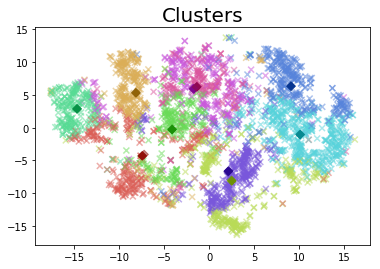

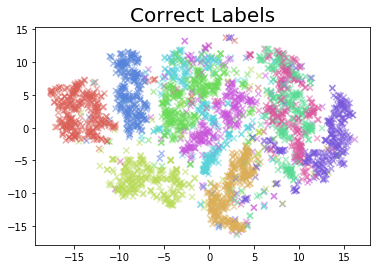

-------------------------------------
  k = 100  
-------------------------------------

0 | Mayority: 2
-------------------------------------
Size: mayority 201 | full: 223
Percentage of majority class: 90.13452914798206 % 


1 | Mayority: 6
-------------------------------------
Size: mayority 231 | full: 266
Percentage of majority class: 86.8421052631579 % 


2 | Mayority: 1
-------------------------------------
Size: mayority 162 | full: 302
Percentage of majority class: 53.64238410596026 % 


3 | Mayority: 3
-------------------------------------
Size: mayority 146 | full: 280
Percentage of majority class: 52.142857142857146 % 


4 | Mayority: 0
-------------------------------------
Size: mayority 237 | full: 248
Percentage of majority class: 95.56451612903226 % 


5 | Mayority: 7
-------------------------------------
Size: mayority 170 | full: 405
Percentage of majority class: 41.9753086419753 % 


6 | Mayority: 4
-------------------------------------
Size: mayority 140 | full: 413

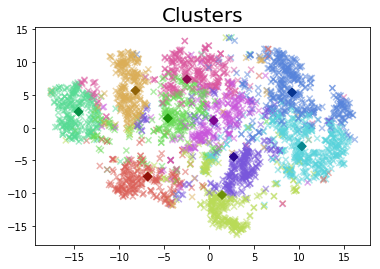

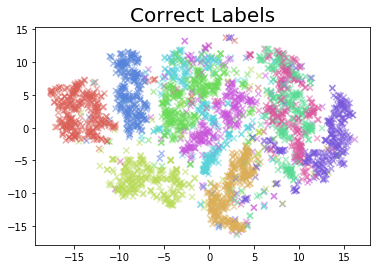

-------------------------------------
  k = 1000  
-------------------------------------

0 | Mayority: 2
-------------------------------------
Size: mayority 201 | full: 223
Percentage of majority class: 90.13452914798206 % 


1 | Mayority: 6
-------------------------------------
Size: mayority 231 | full: 266
Percentage of majority class: 86.8421052631579 % 


2 | Mayority: 1
-------------------------------------
Size: mayority 162 | full: 302
Percentage of majority class: 53.64238410596026 % 


3 | Mayority: 3
-------------------------------------
Size: mayority 146 | full: 280
Percentage of majority class: 52.142857142857146 % 


4 | Mayority: 0
-------------------------------------
Size: mayority 237 | full: 248
Percentage of majority class: 95.56451612903226 % 


5 | Mayority: 7
-------------------------------------
Size: mayority 170 | full: 405
Percentage of majority class: 41.9753086419753 % 


6 | Mayority: 4
-------------------------------------
Size: mayority 140 | full: 41

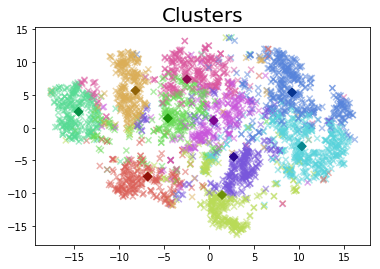

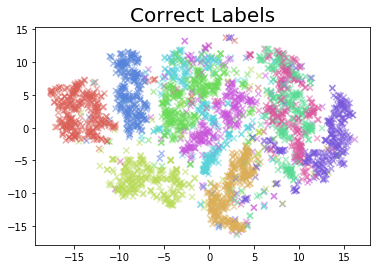

In [14]:
print("-------------------------------------")
print("  k = 10  ")
print("-------------------------------------")
kmeans_train(10, mnist_kmeans["x_train"], mnist_kmeans["y_train"])

print("-------------------------------------")
print("  k = 100  ")
print("-------------------------------------")
kmeans_train(90, mnist_kmeans["x_train"], mnist_kmeans["y_train"])

print("-------------------------------------")
print("  k = 1000  ")
print("-------------------------------------")
mnist_kmeans_wrong_predictions = kmeans_train(900, mnist_kmeans["x_train"], mnist_kmeans["y_train"])

### Oberer Plot: Cluster nach Cluster Nummer (nicht majortiy class) Mit Centroiden und Centroiden der vorherigen itteration (halb transparent) und ´meistens vom neuen centroiden verdeckt
### Unterer Plot: Tatsächliche Ziffern
## Legende
* 0: Rot
* 1: Gold
* 2: Neongelb
* 3: Hellgrün
* 4: Türkis
* 5: Hellblau
* 6: Blau
* 7: Sehr Dunkel Lila
* 8: Lila
* 9: Hell Lila (ähnlich zu rot)



### Do this for 10, 100, 1000 iterations:

<h3>What is the majority class of each cluster? <br>What is the percentage of the majority class in each cluster? </h3>
<p> Siehe Ergebnis der oberen Zelle </p>

### Does each number have a cluster?
<p> Nein.</p>

### If not, which hasn’t?

<p> Siehe Ergebnis der oberen Zelle (not represented) </p>

## D MNIST understanding

##### Some numbers are more difficult to predict with KNN and to cluster with K-means. Show why.  Start with examples, and get more general

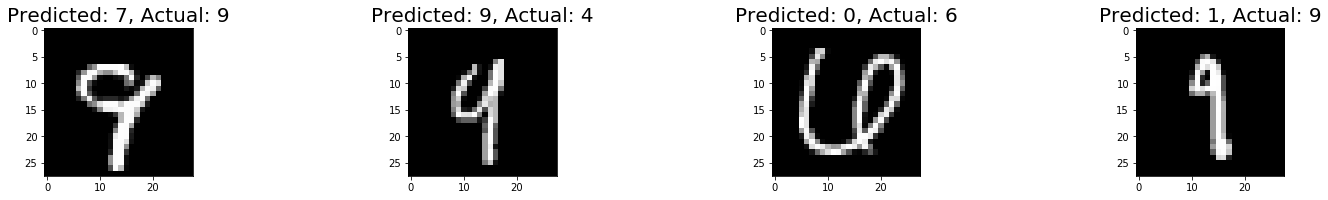

In [15]:
size = mnist_knn_wrong_predictions.shape[0]
if size >= 1:
    show_wrong_predictions(mnist_knn_wrong_predictions, mnist_knn["x_test"], int(size/4*6), False)
else:
    print("No wrong predictions")

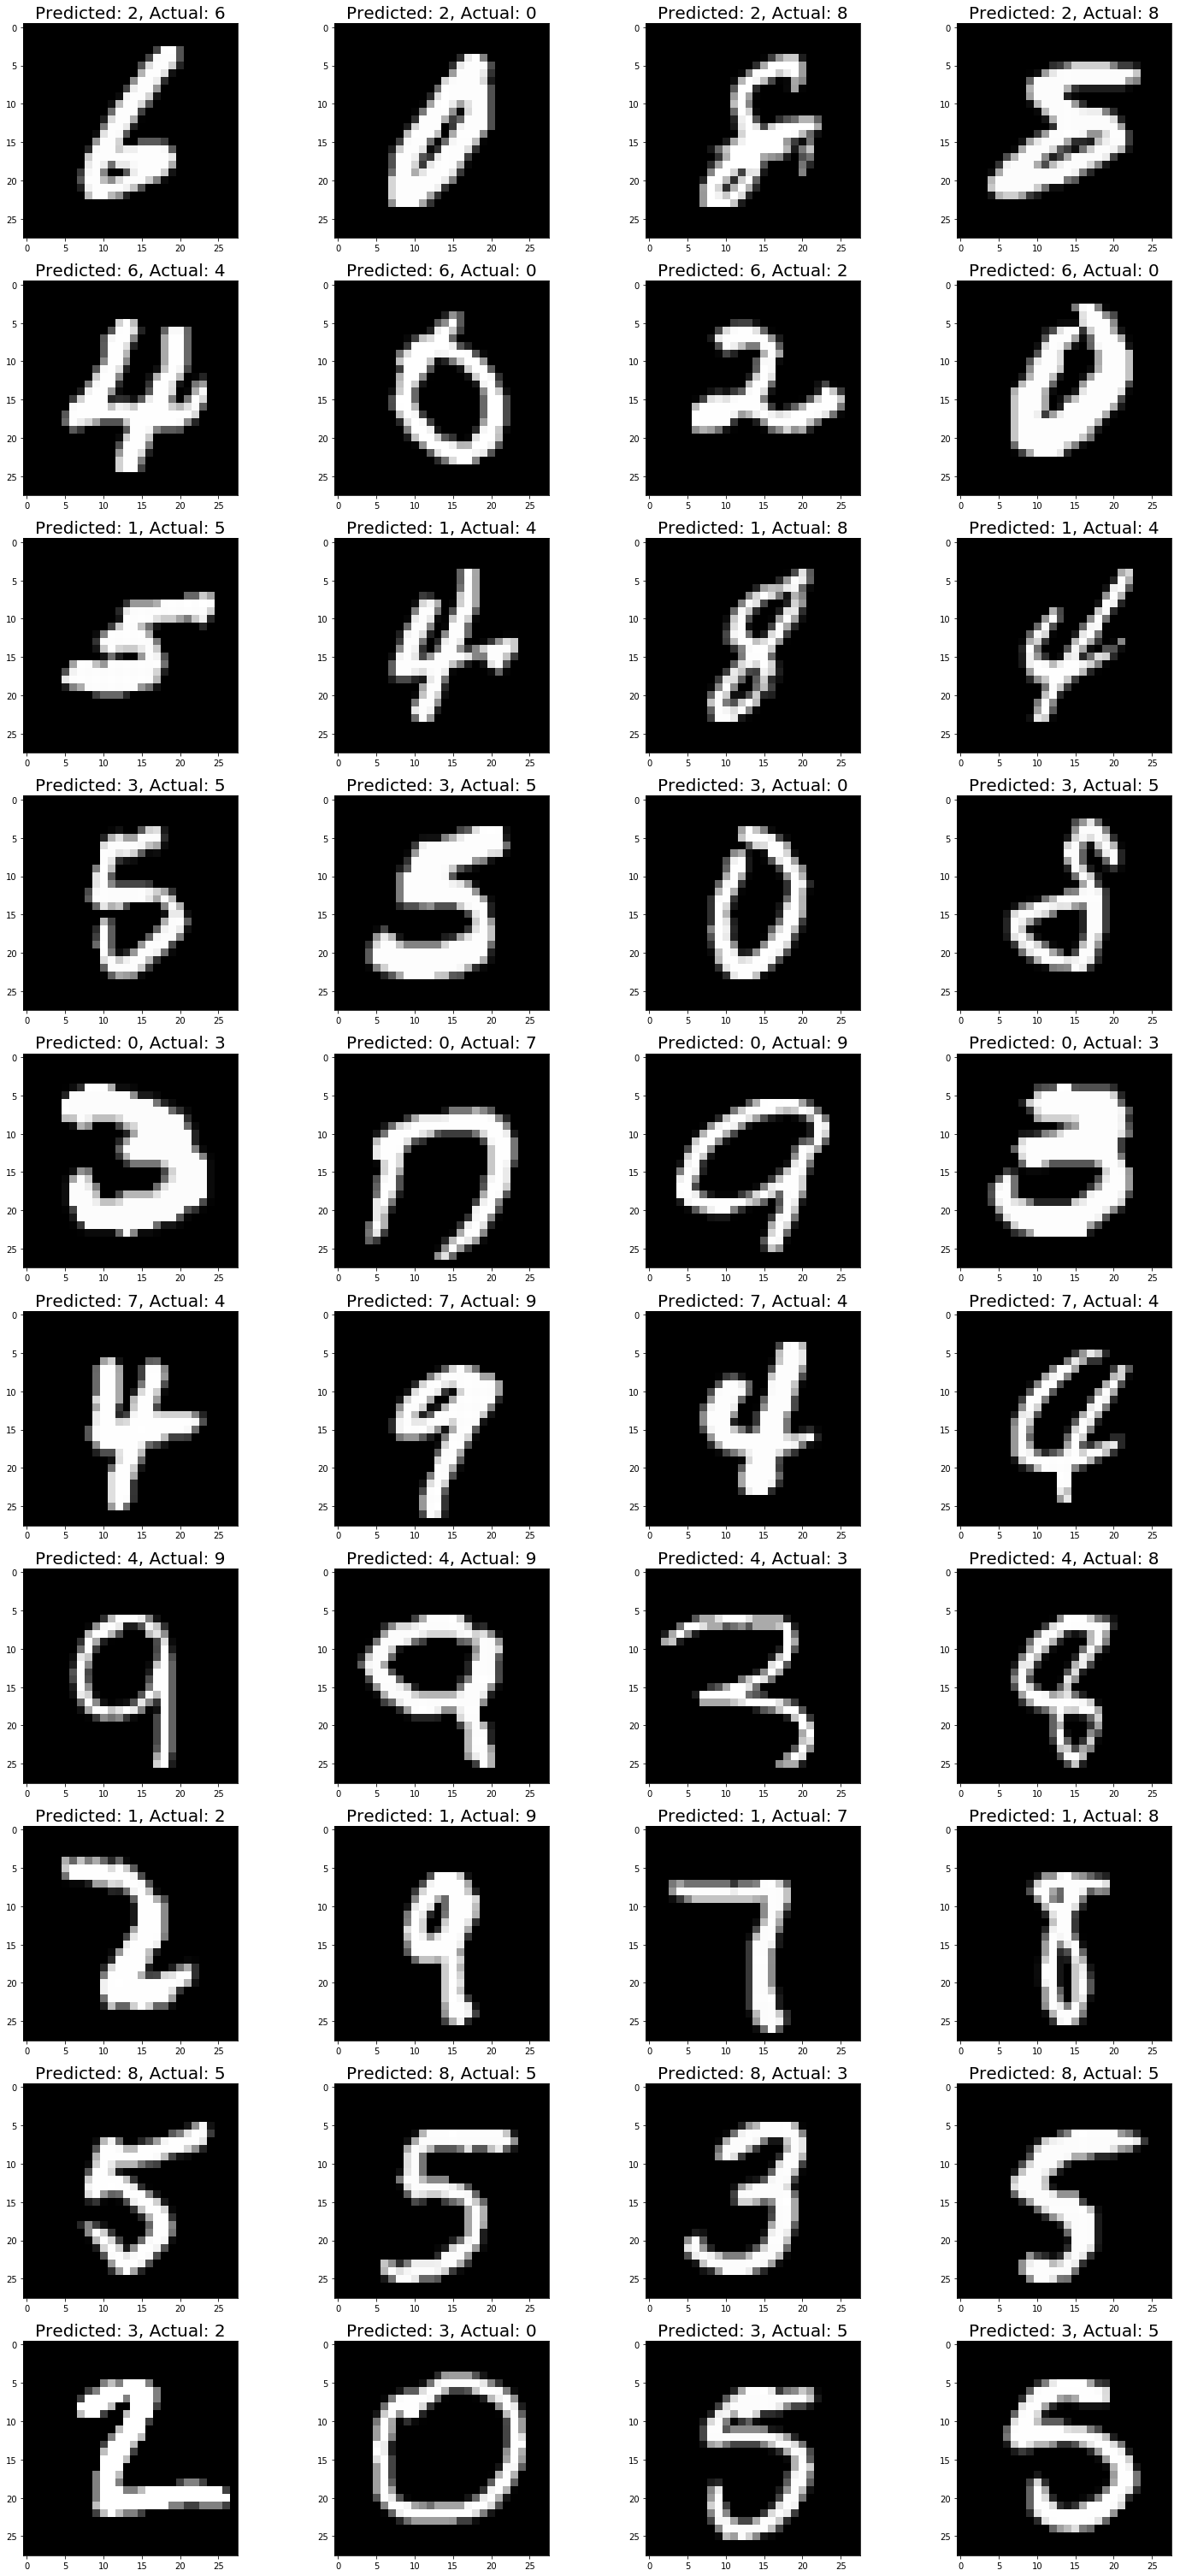

In [16]:
size = mnist_kmeans_wrong_predictions.shape[0]
if size >= 1:
    show_wrong_predictions(mnist_kmeans_wrong_predictions, mnist_kmeans["x_train"], int(size/4*6), False)
else:
    print("No wrong predictions")

### Fazit:
<p>Schauen wir uns nun die Sammlung der falsch eingeordneten Zahlen an, so sehen wir, dass viele Pixel mit denen, der geratenen Zahlen überein stimmen. Sie ähneln mehr den geratenen Zahlen als den richtigen. Mit ähneln ist gemeint, dass mehr Pixel "übereinstimmen"(Schnittmenge der Pixel mit ähnlicher "Helligkeit" - größerer Helligkeitsunterschied = weniger übereinstimmung = größere Abstände bei der Distanzberechnung). Knn erkennt nämlich nicht, wo die Pixel sich im Bild befinden, bzw. erkennt nicht die Zusammenhänge zwischen den Positionen der Pixel, sondern nur deren Werte (Da jeder Pixel den Wert für eine Dimension bie der Distanzberechnung bestimmt ist jede "Pixel-Achse" von jeder "gleiwchweit entfernt" wodurch der Context in dem die Pixel zueinander stehen verloren geht)</p>

<p> Bei k-means werden diese falschzuordnung noch weiter verstärkt, da die Zahlen, die fälschlicherweiße eingeordnet werden, zur Neuzuordnung in der nächsten Itteration als Vergelcihsdaten beitragen.</p>
<p>Bsp. in der ersten Itteration werden viele 5er und einige 8er in einen einzigen cluster gepackt, was dazu führt, dass der neue Zentroid vermutlich eine 8 wird, die viele Ähnlichkeiten mit einer 5 aufweißt. Bei der nächsten Itteration werden dadurch dann noch alle anderen Ziffern, die ähnlich aussehen wie 5er und 8er hinzugefügt.</p>
<p> Da k-means die Labels der Ziffern nicht kennt, geht es dann davon aus, dass es nicht die Ziffern 5 und 8 gibt, sondern eine Ziffer die so aussieht wie die Mischung aus beiden</p>

## E KNN and K-means CIFAR

### transform cifar-10 to grayscale.
Siehe oben beim Laden von CIFAR

## Demonstrate this similar to B, C and D

## E.B KNN

In [17]:
cifar_knn = get_cifar_subsets(10000,50)

In [18]:
predictions2 = knn(2, cifar_knn["x_train"], cifar_knn["y_train"], cifar_knn["x_test"])
predictions4 = knn(4, cifar_knn["x_train"], cifar_knn["y_train"], cifar_knn["x_test"])
predictions8 = knn(8, cifar_knn["x_train"], cifar_knn["y_train"], cifar_knn["x_test"])

print(list(y_cifar_test), "\n")

print("-------------------------------------")
print("  2NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions2, "\n")
print_error_rate(y_cifar_test, predictions2)

print("-------------------------------------")
print("  4NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions4, "\n")
print_error_rate(y_cifar_test, predictions4)

print("-------------------------------------")
print("  8NN  ")
print("-------------------------------------")
print("Predictions:")
print(predictions8, "\n")
cifar_knn_wrong_predictions = print_error_rate(y_cifar_test,predictions8)


[9, 2, 3, 1, 9, 7, 1, 0, 5, 0, 2, 1, 4, 1, 6, 8, 4, 5, 5, 1, 2, 9, 0, 0, 4, 2, 4, 7, 7, 5, 3, 8, 8, 3, 7, 1, 5, 0, 8, 6, 7, 1, 1, 5, 3, 6, 2, 5, 0, 3] 

-------------------------------------
  2NN  
-------------------------------------
Predictions:
[8, 4, 4, 2, 1, 3, 2, 8, 2, 4, 2, 1, 4, 1, 3, 5, 2, 5, 4, 3, 2, 6, 0, 8, 3, 2, 2, 0, 4, 4, 3, 8, 8, 3, 0, 1, 6, 0, 4, 3, 4, 1, 4, 4, 3, 3, 4, 1, 8, 6] 

Label: 0
   2 out of 6 recognized correctly | Errorrate: 66.66666666666667 %
Label: 1
   4 out of 8 recognized correctly | Errorrate: 50.0 %
Label: 2
   3 out of 5 recognized correctly | Errorrate: 40.0 %
Label: 3
   3 out of 5 recognized correctly | Errorrate: 40.0 %
Label: 4
   1 out of 4 recognized correctly | Errorrate: 75.0 %
Label: 5
   1 out of 7 recognized correctly | Errorrate: 85.71428571428572 %
Label: 6
   0 out of 3 recognized correctly | Errorrate: 100.0 %
Label: 7
   0 out of 5 recognized correctly | Errorrate: 100.0 %
Label: 8
   2 out of 4 recognized correctly | Errorrate: 

### What is the error rate of KNN on the test set?
Siehe Ergebnis der oberen Zelle

### What is the error rate for each label (number)?
Siehe Ergebnis der oberen Zelle

### How does the choice of k influence the result?

Beim Testen mit anderen Subsets ist aufgefallen, dass k sich nicht stark auf die Errorquote auswirkt, aber k=2 und k=4 tendenziell niedrigere Errorraten für unsere Test- und Traingrößen hatte.

### Does knn work similarly good for cifar?
<p>Nein. Obwohl manche Trainingssets mit einer Errorate von weniger als 70% ca. 20% besser waren als zufälliges raten, ist das nicht mit den weniger als 10% bzw. häufig auch weniger als 5% Errorraten unserer knn Testreihen zu vergleichen. Grund dafür ist, dass Bilder von den gleichen Dingen im gegensatz zu Bildern von den gleichen Ziffern nicht ähnlich aussehen.</p>
<p>Bsp.: Ein stark überbelichtetes Bild und ein stark unterbelichtetes Bild von einem Hund haben sehr unterschiedliche Werte für ihre Graustufen pixel (hellgrau / schwarz). Während ein überbelichtetes Bild von einem Hund und ein überbelichtetes Bild von einem Lkw sehr ähnliche Werte für die einzelnen Pixel haben (hellgrau/hellgrau)</p>
<p>Außerdem sorgen noch andere Faktoren, wie zum Beispiel verschiedene Blickwinkel und "Zuschnitte" dafür, dass selbst bei gleicher Beleuchtung, sich Bilder von den gleichen Objekten nicht ähnlich sehen (auf einer Pixel für Pixel Basis)</p>

## E.C K-means CIFAR

In [19]:
cifar_kmeans = get_cifar_subsets(3000,0)
k_cifar = 10
kmeans_start(cifar_kmeans["x_train"], k_cifar)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.232s...
[t-SNE] Computed neighbors for 3000 samples in 16.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 427.303336
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.604416
[t-SNE] KL divergence after 300 iterations: 2.283461


-------------------------------------
  k = 10  
-------------------------------------

0 | Mayority: 2
-------------------------------------
Size: mayority 61 | full: 427
Percentage of majority class: 14.285714285714285 % 


1 | Mayority: 5
-------------------------------------
Size: mayority 61 | full: 213
Percentage of majority class: 28.638497652582164 % 


2 | Mayority: 9
-------------------------------------
Size: mayority 89 | full: 303
Percentage of majority class: 29.372937293729372 % 


3 | Mayority: 4
-------------------------------------
Size: mayority 42 | full: 262
Percentage of majority class: 16.030534351145036 % 


4 | Mayority: 4
-------------------------------------
Size: mayority 64 | full: 284
Percentage of majority class: 22.535211267605636 % 


5 | Mayority: 7
-------------------------------------
Size: mayority 51 | full: 302
Percentage of majority class: 16.887417218543046 % 


6 | Mayority: 0
-------------------------------------
Size: mayority 63 | full: 203


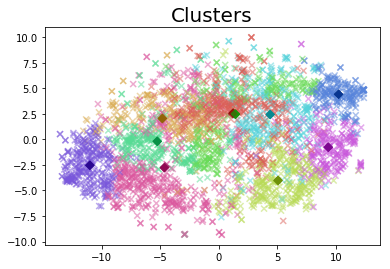

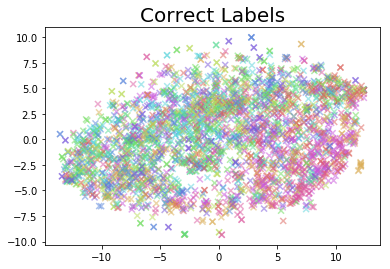

-------------------------------------
  k = 100  
-------------------------------------

0 | Mayority: 2
-------------------------------------
Size: mayority 70 | full: 441
Percentage of majority class: 15.873015873015872 % 


1 | Mayority: 5
-------------------------------------
Size: mayority 66 | full: 245
Percentage of majority class: 26.93877551020408 % 


2 | Mayority: 9
-------------------------------------
Size: mayority 95 | full: 317
Percentage of majority class: 29.96845425867508 % 


3 | Mayority: 3
-------------------------------------
Size: mayority 40 | full: 231
Percentage of majority class: 17.316017316017316 % 


4 | Mayority: 4
-------------------------------------
Size: mayority 63 | full: 269
Percentage of majority class: 23.42007434944238 % 


5 | Mayority: 7
-------------------------------------
Size: mayority 54 | full: 293
Percentage of majority class: 18.43003412969283 % 


6 | Mayority: 0
-------------------------------------
Size: mayority 64 | full: 204
Per

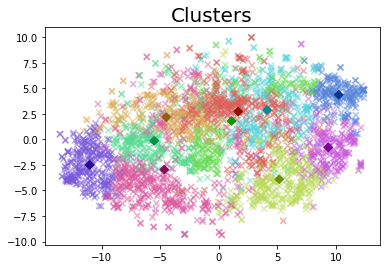

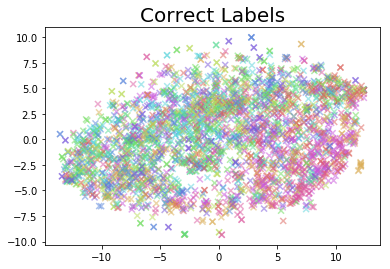

-------------------------------------
  k = 1000  
-------------------------------------

0 | Mayority: 2
-------------------------------------
Size: mayority 70 | full: 441
Percentage of majority class: 15.873015873015872 % 


1 | Mayority: 5
-------------------------------------
Size: mayority 66 | full: 245
Percentage of majority class: 26.93877551020408 % 


2 | Mayority: 9
-------------------------------------
Size: mayority 95 | full: 317
Percentage of majority class: 29.96845425867508 % 


3 | Mayority: 3
-------------------------------------
Size: mayority 40 | full: 231
Percentage of majority class: 17.316017316017316 % 


4 | Mayority: 4
-------------------------------------
Size: mayority 63 | full: 269
Percentage of majority class: 23.42007434944238 % 


5 | Mayority: 7
-------------------------------------
Size: mayority 54 | full: 293
Percentage of majority class: 18.43003412969283 % 


6 | Mayority: 0
-------------------------------------
Size: mayority 64 | full: 204
Pe

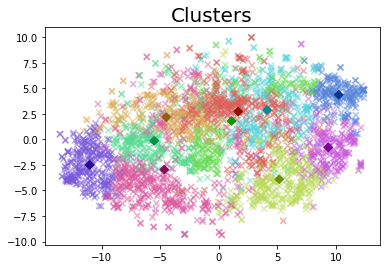

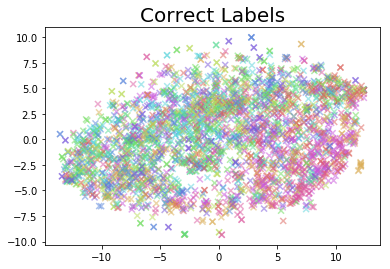

In [20]:
print("-------------------------------------")
print("  k = 10  ")
print("-------------------------------------")
kmeans_train(10, cifar_kmeans["x_train"] ,cifar_kmeans["y_train"])

print("-------------------------------------")
print("  k = 100  ")
print("-------------------------------------")
kmeans_train(90, cifar_kmeans["x_train"] ,cifar_kmeans["y_train"])

print("-------------------------------------")
print("  k = 1000  ")
print("-------------------------------------")
cifar_kmeans_wrong_predictions = kmeans_train(900, cifar_kmeans["x_train"] ,cifar_kmeans["y_train"])

### Do this for 10, 100, 1000 iterations:

<h3>What is the majority class of each cluster? <br>What is the percentage of the majority class in each cluster? </h3>
<p> Siehe Ergebnis der oberen Zelle </p>

### Does each number have a cluster?
<p> Nein.</p>

### If not, which hasn’t?

<p> Siehe Ergebnis der oberen Zelle (not represented) </p>

### Does k-means work similarly good for cifar?

<p>Nein. CIFAR hat mayority-classes im Bereich von 10-40% während MNIST Bereiche von 40-95% hat. Betrachtet man das Diagramm der korrekten CIFAR Daten, kann man kein Muster innerhalb des Datensatzes erkennen. Alle Punkte sind viel enger zusammen und miteinander vermischt und nicht in Clustern von gleichen Labels geordnet. Dies wird besonders deutlich, wenn man es mit dem Diagramm des MNIST-Datensatzes vergleicht</p>

## E.D CIFAR understanding

##### Some numbers are more difficult to predict with KNN and to cluster with K-means. Show why.  Start with examples, and get more general

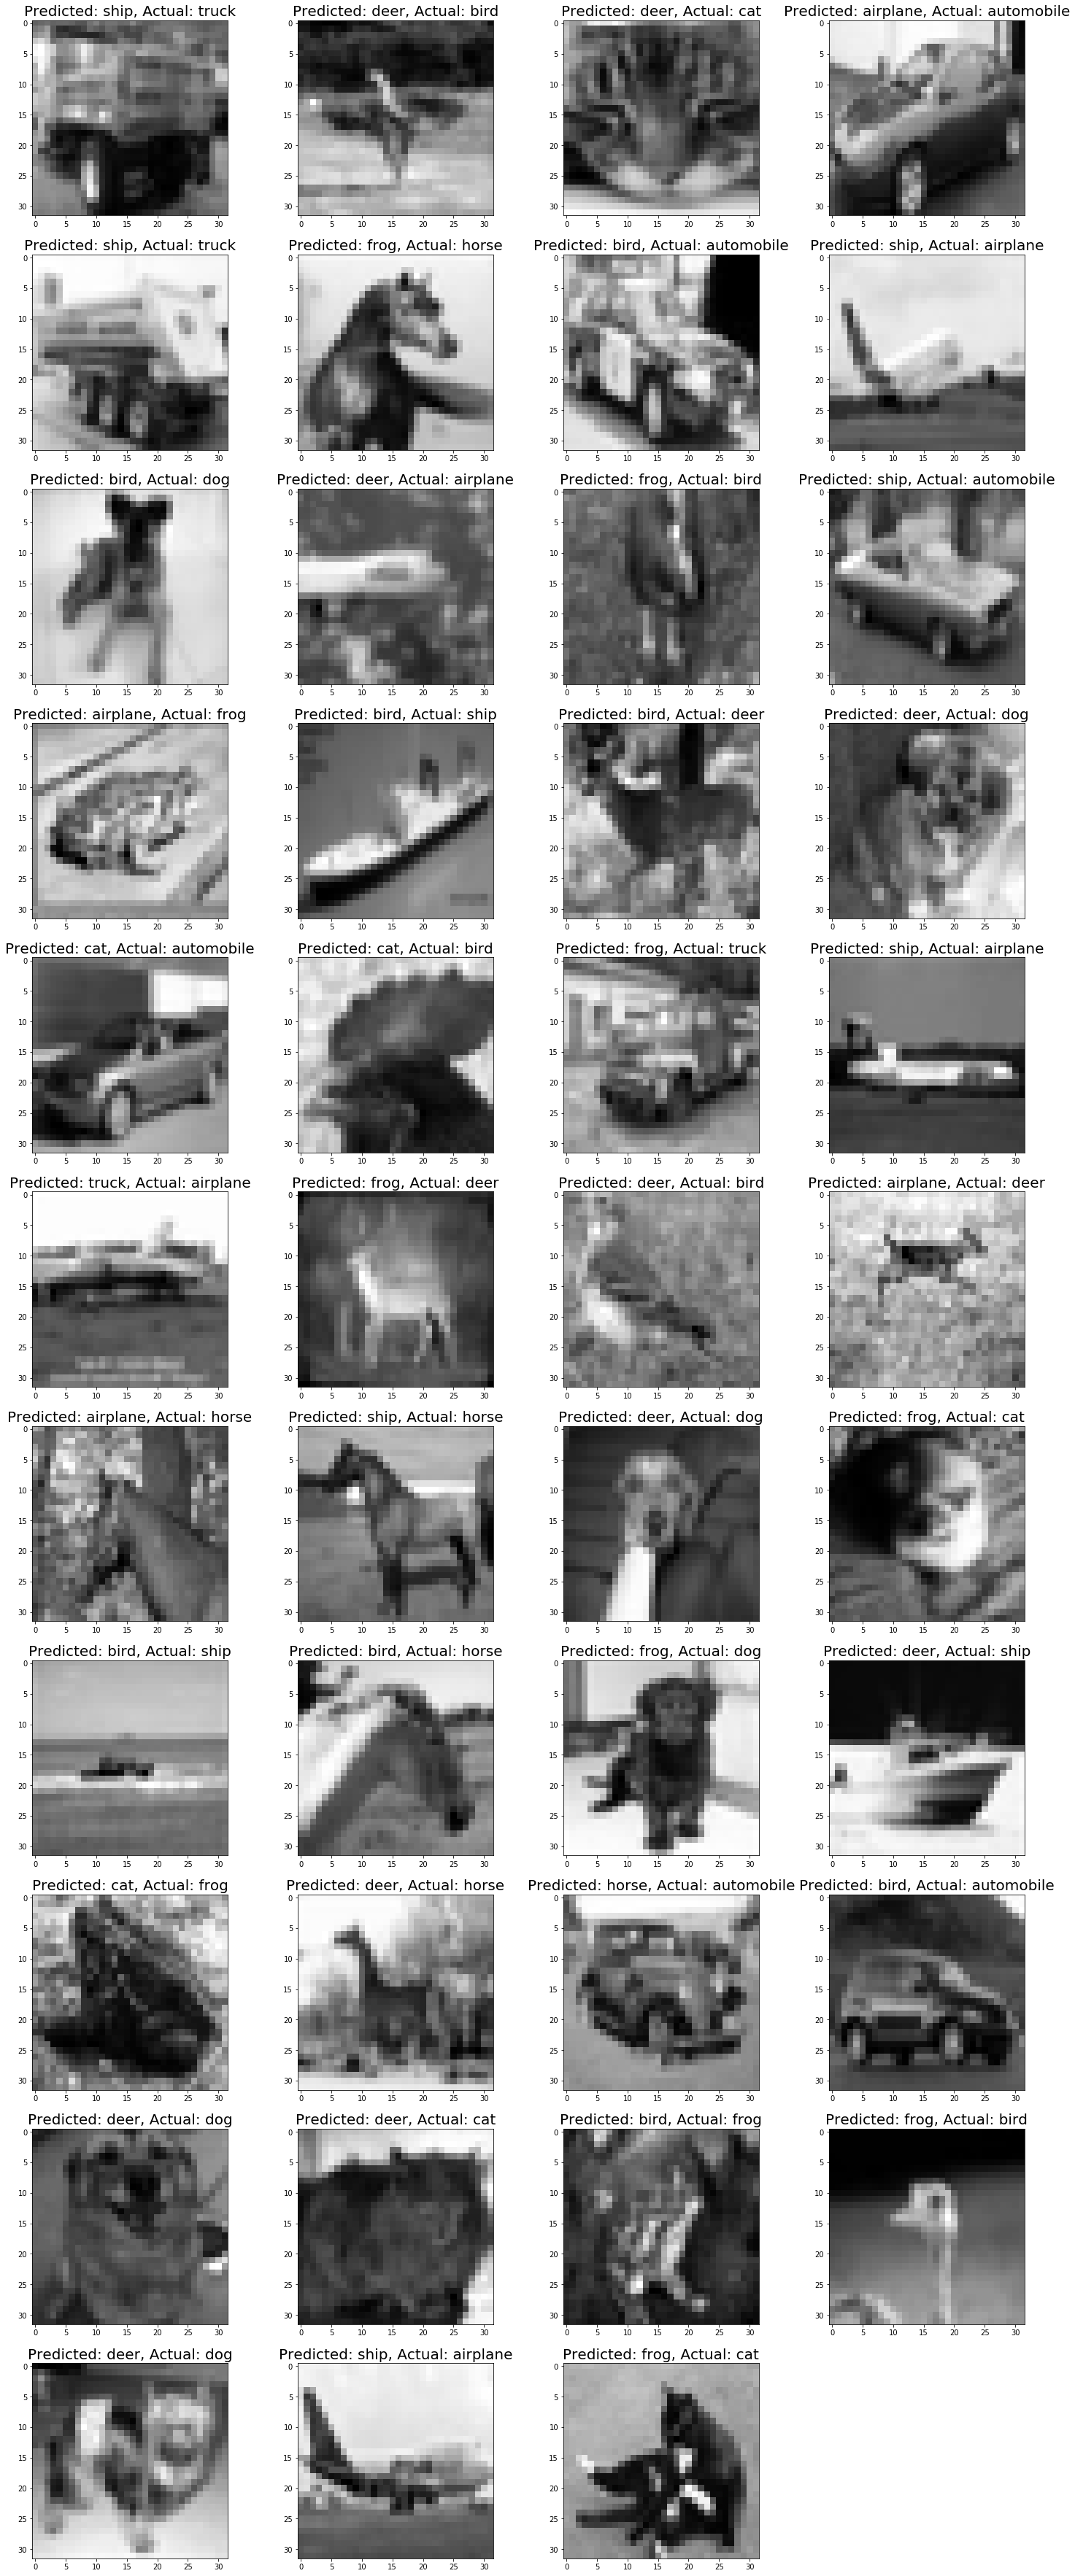

In [21]:
size = cifar_knn_wrong_predictions.shape[0]
if size >= 1:
    show_wrong_predictions (cifar_knn_wrong_predictions, cifar_knn["x_test"], int(size/4*6), True)
else:
    print("No wrong predictions")

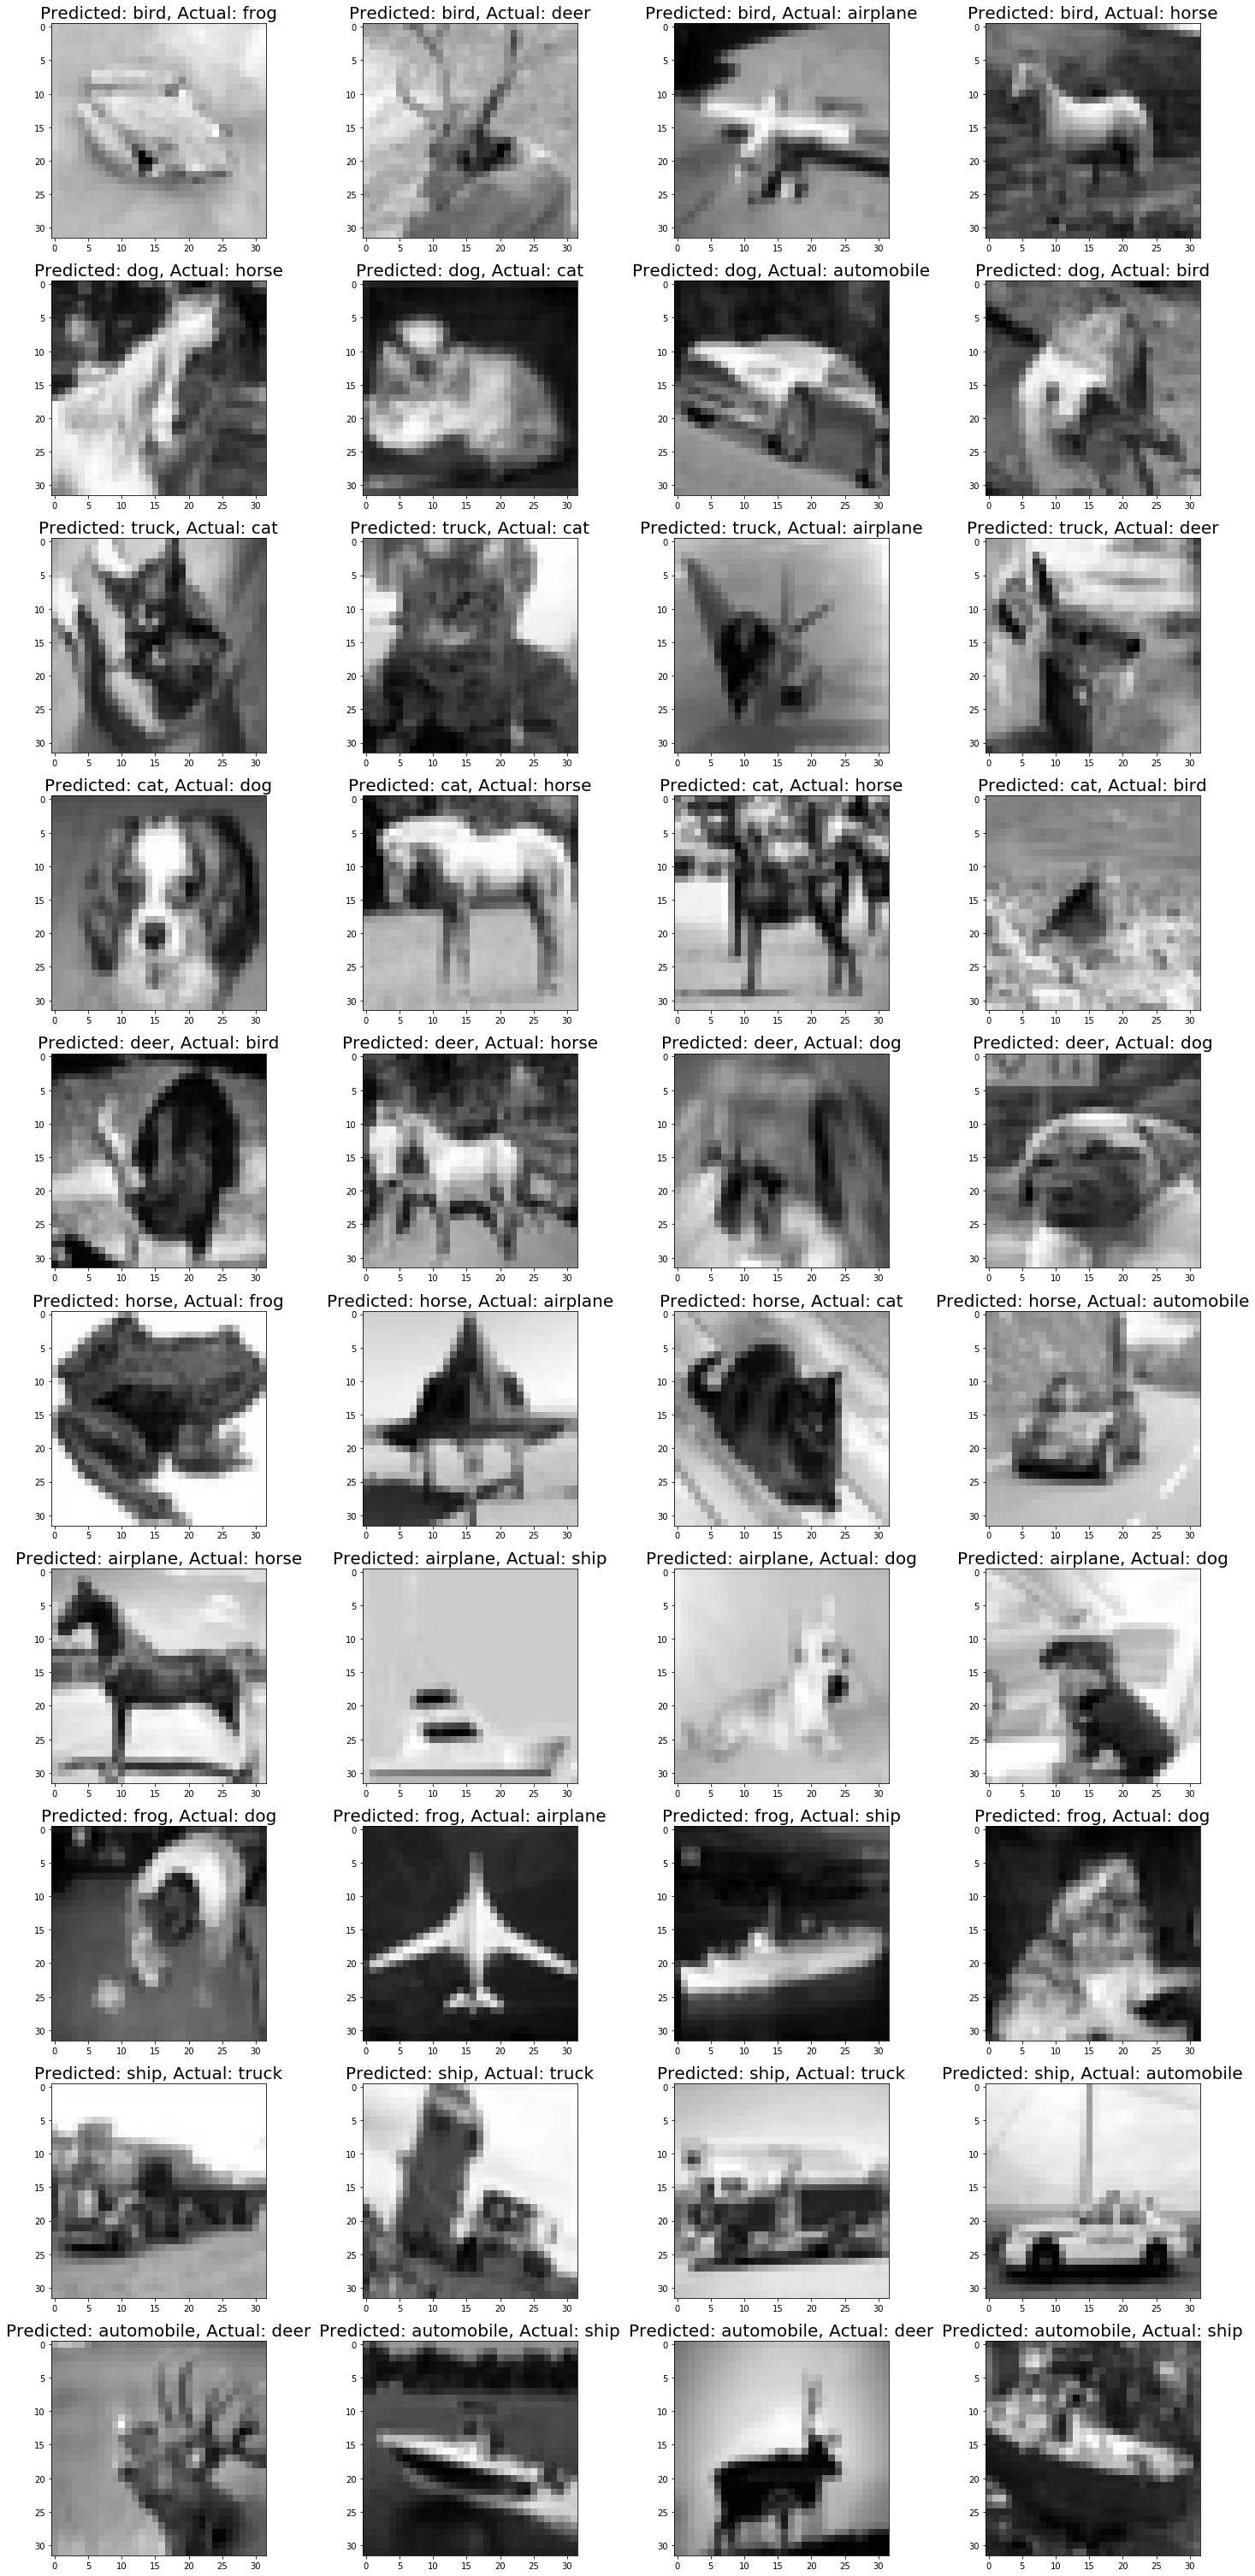

In [22]:
size = cifar_kmeans_wrong_predictions.shape[0]
if size >= 1:
    show_wrong_predictions (cifar_kmeans_wrong_predictions, cifar_kmeans["x_train"], int(size/4*6), True)
else:
    print("No wrong predictions")

### Fazit
CIFAR ist weder für knn noch für k-means wirklich geeignet, da die Schnittmengen der Graustufen-Pixelmaps der Bilder innerhalb einer Klasse nicht wirklich ähnlicher sind als die zwischen den Klassen.

## F Linear regression BOSTON

Train a linear regression model on the BOSTON dataset to predict median
values of houses. Test it on the test set. Show the code how you did it! What
dependent variables (columns) have the biggest influence?

In [23]:
#Load Data

boston_dataset = load_boston()

boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

#Add median Value row
boston['MEDV'] = boston_dataset.target

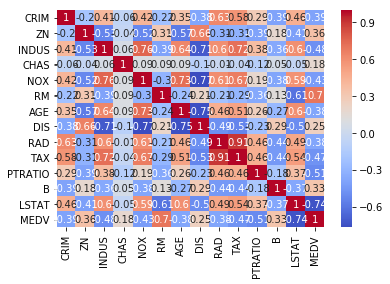

In [24]:
#Correlation Matrix
correlation_matrix = boston.corr().round(2)

sns.heatmap(data= correlation_matrix, annot=True, cmap="coolwarm")

#### The feature rm [5] (rooms) has the biggest postive impact 
#### The feature lstat [12] (lower status of the population)  has the biggest negative impact 

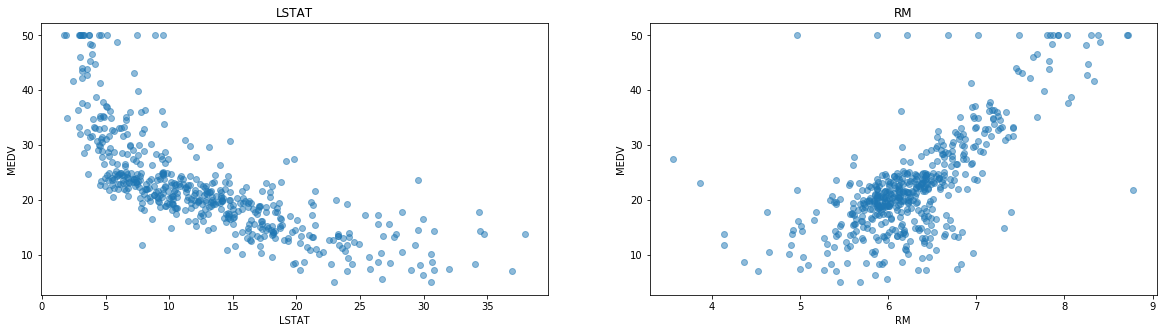

In [25]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o', alpha=0.5)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

### Conclusion
The prices increase as the value of RM increases linearly.

The prices tend to decrease with an increase in LSTAT. Though it doesn’t look to be following exactly a linear line.

### Linear Regression

In [26]:
#Load data an split Data

boston = tf.keras.datasets.boston_housing.load_data()
X_train = boston[0][0]
Y_train = boston[0][1]

X_test = boston[0][0]
Y_test = boston[0][1]



predict the value of a house we want to sell:
Values: 
[  1.2940935   0.          8.547       0.          0.5649      6.4491
  96.285       4.175745    4.2       322.35       22.05      416.745
  19.656    ]
Fictional price: [14.39226745]


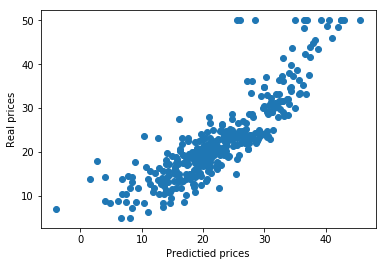

In [27]:
#Function Linear Regression
lr = LinearRegression()

#Train both sets
lr.fit(X_train, Y_train)

#Add prediction
prediction = lr.predict(X_test)

#Show 

plt.scatter(prediction, Y_test)
plt.xlabel("Predictied prices")
plt.ylabel("Real prices")

print("\n")

#predict the value of a house 
print("predict the value of a house we want to sell:")
fictional_house = X_train[0]*1.05
print("Values: \n{}".format(fictional_house))
fictonal_price = lr.predict(fictional_house.reshape(1, -1))
print("Fictional price: {}".format(fictonal_price))

MSE: 31.968913812973774
Blue = original regression
Orange = regression with two most significant features


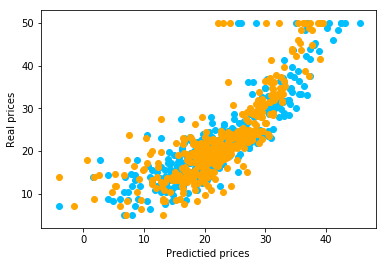

In [28]:
#Predict prices with most significant features
#rm & Lstat
arr = [5, 12]

lr.fit(X_train[:, arr], Y_train)
pred_best = lr.predict(X_test[:, arr])
plt.scatter(prediction, Y_test, c="deepskyblue")
plt.scatter(pred_best, Y_test, c="orange")
plt.xlabel("Predictied prices")
plt.ylabel("Real prices")
print("MSE: {}".format(sklearn.metrics.mean_squared_error(Y_test, pred_best)))
print("Blue = original regression")
print("Orange = regression with two most significant features")

In [29]:
rmse = (np.sqrt(sklearn.metrics.mean_squared_error(Y_train, prediction)))
r2 = sklearn.metrics.r2_score(Y_train, prediction)

print("Model Performance for the Training set")
print("--------------------------------------")
print("Root mean square error is {}".format(rmse))
print("R2 score is {}".format(r2))

Model Performance for the Training set
--------------------------------------
Root mean square error is 4.690927502994279
R2 score is 0.7399643695249463


# G Logistik regression MNIST
Evalute logistic regression as B and D on MNIST

In [30]:
mnist_reg = get_mnist_subsets(5000, 100)

In [31]:
lr = LogisticRegression(multi_class='auto',solver='lbfgs', max_iter=500)
results = lr.fit(mnist_reg["x_train"], mnist_reg["y_train"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## E.B Logistik Regression

In [32]:
y_pred = lr.predict(mnist_reg["x_test"])
print(sklearn.metrics.classification_report(mnist_reg["y_test"], y_pred))
mnist_reg_wrong_predictions = print_error_rate(mnist_reg["y_test"], y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         6
           5       0.88      1.00      0.93         7
           6       1.00      1.00      1.00         8
           7       1.00      0.89      0.94         9
           8       1.00      0.83      0.91         6
           9       0.86      1.00      0.92         6

   micro avg       0.98      0.98      0.98       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.98      0.98      0.98       100

Label: 0
   16 out of 16 recognized correctly | Errorrate: 0.0 %
Label: 1
   18 out of 18 recognized correctly | Errorrate: 0.0 %
Label: 2
   13 out of 13 recognized correctly | Errorrate: 0.0 %
Label: 3
   11 out of 11 recognized correctly 

### What is the error rate of Log-Regression on the test set?
Siehe Ergebnis der oberen Zelle

### What is the error rate for each label (number)?
Siehe Ergebnis der oberen Zelle


## E.D MNIST understanding

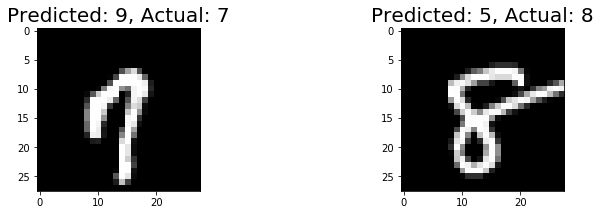

In [33]:
size = mnist_reg_wrong_predictions.shape[0]
if size >= 1:
    show_wrong_predictions(mnist_reg_wrong_predictions, mnist_reg["x_test"], int(size/4*6), False)
else:
    print("No wrong predictions")

### Fazit
Logistische Regression 

# H Feedback

* How much time did you work on this assignment and how often did you meet?  
ca. 17 Stunden; 4 Mal
* Did you use Google Colab or Anaconda?  
Anaconda
* What was your favourite excercise? Why?  
C/D Ich mochte die Visualisierung der Punkte / Bilder
* What excercise did you like least? Why?  
Lineare Regression, mir hat der Zusammenhang zur Vorlesung gefehlt und ich fande sie etwas zu offen formuliert. z.B. wird nach keine einzige Gerade gefragt (visualisierung)